In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [3]:
from preprocess import divide_to_train_and_test, one_hot
from confusion_matrix import print_confusion_matrix

In [4]:
def load_from_directory(texts_directory, images_directory, target_names, max_files_in_one_category=30000):
    file_texts = []
    targets = []
    
    for root, dirs, files in os.walk(images_directory):
        number_used_files = 0
        for name in files:
            if number_used_files < max_files_in_one_category:
            
                name_without_extenstion, _ = os.path.splitext(name)
                
                _, cur_target = os.path.split(root)
                cur_target = target_names.index(cur_target)
            
                text_name = name_without_extenstion + ".txt"
                cur_text_path =  os.path.join(texts_directory, text_name)
                
                try:
                    with open(cur_text_path, encoding="utf-16") as file:
                
                        # считываем файл построчно
                        file_text = ""
                        for line in file.readlines():
                            file_text += (line)
                        if file_text != "" and file_text != " ":
                            file_texts.append(file_text[2:])
                            targets.append(cur_target)
                
                            number_used_files += 1            
                except:
                    print("PROBLEM WITH FILE", cur_text_path)
                
    return file_texts, targets


In [5]:
CATEGORIES_COUNT = 7

In [6]:
%%time
file_texts, targets = load_from_directory(texts_directory="D:/svruchtel/DATA/France_New/Texts",
                                         images_directory="D:/svruchtel/DATA/France_New_ByMeaning", 
                                         target_names = ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                                        "Taxi", "TollRoad", "Transport"])

Wall time: 1.59 s


In [7]:
text_1 = file_texts[0]
print(text_1)

TAL
RELAIS TOTAL ACCESS EOUGIVAL
TOTAL MARKETING FRANCE
SAS au capital de 39C 553 339 Euro
562 avenue du parc de l'11e
92000 Nanterre - Frarce
37,76 litre pompe 03
GO f E JR 50 00 M
1,324 EUR /litre
Total EJR 50,00
CB EJR 50,00
20,00 % TVA M EJR 8,33
Date Heure Num POS CN° Quart
09/03/17 08:15 59111 11 00J6 051
Vente de carburant faite en mandat
d’ordre et pour le compte Je :
TOTAL MARKETING FRANCE
SAS au capital de 39C 553 339 Euro
562 avenue du parc de T ils
92000 Nanterre - Frarce
531 680 445 RCS Nanterre
No TVA INTRACOM : FR 22 531 680 44�
TOTAL vous remercie ce votre visite
Bonde route et à bientôt



In [8]:
#print(list(text_1))

text_new = [char for char in list(text_1) if (char != ' ' and char != '\n')]
print(text_new)


['T', 'A', 'L', 'R', 'E', 'L', 'A', 'I', 'S', 'T', 'O', 'T', 'A', 'L', 'A', 'C', 'C', 'E', 'S', 'S', 'E', 'O', 'U', 'G', 'I', 'V', 'A', 'L', 'T', 'O', 'T', 'A', 'L', 'M', 'A', 'R', 'K', 'E', 'T', 'I', 'N', 'G', 'F', 'R', 'A', 'N', 'C', 'E', 'S', 'A', 'S', 'a', 'u', 'c', 'a', 'p', 'i', 't', 'a', 'l', 'd', 'e', '3', '9', 'C', '5', '5', '3', '3', '3', '9', 'E', 'u', 'r', 'o', '5', '6', '2', 'a', 'v', 'e', 'n', 'u', 'e', 'd', 'u', 'p', 'a', 'r', 'c', 'd', 'e', 'l', "'", '1', '1', 'e', '9', '2', '0', '0', '0', 'N', 'a', 'n', 't', 'e', 'r', 'r', 'e', '-', 'F', 'r', 'a', 'r', 'c', 'e', '3', '7', ',', '7', '6', 'l', 'i', 't', 'r', 'e', 'p', 'o', 'm', 'p', 'e', '0', '3', 'G', 'O', 'f', 'E', 'J', 'R', '5', '0', '0', '0', 'M', '1', ',', '3', '2', '4', 'E', 'U', 'R', '/', 'l', 'i', 't', 'r', 'e', 'T', 'o', 't', 'a', 'l', 'E', 'J', 'R', '5', '0', ',', '0', '0', 'C', 'B', 'E', 'J', 'R', '5', '0', ',', '0', '0', '2', '0', ',', '0', '0', '%', 'T', 'V', 'A', 'M', 'E', 'J', 'R', '8', ',', '3', '3', 'D',

In [9]:
#let's try to write another version of "load_embeddins"

def load_embeddings(emb_path, max_embeddings_count=100000):
    emb_word_id_to_vector = {}
    word_to_id = {}
    current_word_id = 0
    with open(emb_path, 'r', encoding='utf-8') as f:
        for line in f:
            if current_word_id <= max_embeddings_count:
                line_split = line.strip().split(" ")
                word = line_split[0]
                word_emb = np.array(line_split[1:], dtype=float)
            
                if word_emb.shape != (300,):
                    print("ERROR! Shape is", word_emb.shape, word)
                    continue
            
                word_to_id[word] = current_word_id
                emb_word_id_to_vector[current_word_id] = word_emb
                current_word_id += 1
            else:
                break
            
    return emb_word_id_to_vector, word_to_id

In [11]:
%%time
emb_char_id_to_vector, char_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/glove.840B.300d/glove.840B.300d-char-fr.txt", 
                                    max_embeddings_count=300000)

ERROR! Shape is (299,) 0.37558
Wall time: 97.3 ms


In [12]:
print(emb_char_id_to_vector[0][:7])
print(emb_char_id_to_vector[1][:7])
print(emb_char_id_to_vector[112][:7])

[-0.5144   0.68382  0.65442 -0.18825 -0.10498 -0.83316 -0.224  ]
[ 0.159886 -0.617507 -0.032783  0.1499   -0.26142  -0.240116  0.228819]
[ 0.053742 -0.460417  0.103149  0.107124 -0.206126  0.022789  0.028764]


In [14]:
char_to_id['0']

49

In [15]:
def change_texts_to_lists_of_character_embeddings(X, emb_char_id_to_vector, char_to_id, characters_count=3000):
    """
    X - list of strings (original texts)
    """
    
    X_emb = []
    for text in X:
        text_chars = [char for char in list(text) if (char != ' ' and char != '\n')]
        
        embedded_text = []
        current_chars_count = 0
        
        for char in text_chars:
            if current_chars_count < characters_count:
                if char in char_to_id:
                    embedded_text.append(emb_char_id_to_vector[char_to_id[char]])
                    current_chars_count += 1
                elif char.lower() in char_to_id:
                    embedded_text.append(emb_char_id_to_vector[char_to_id[char.lower()]])
                    current_chars_count += 1
                else:
                    print("There is no embedding to char:", char)
        
        # if text is less long than need to be
        while current_chars_count < characters_count:
            embedded_text.append(emb_char_id_to_vector[char_to_id['0']])
            current_chars_count += 1    
        
        X_emb.append(np.array(embedded_text))
        
    return np.array(X_emb)

In [16]:
%%time
X_emb = change_texts_to_lists_of_character_embeddings(file_texts, emb_char_id_to_vector, char_to_id, characters_count=100)

There is no embedding to char: ■
There is no embedding to char: �
There is no embedding to char: €
There is no embedding to char: €
There is no embedding to char: �
There is no embedding to char: �
There is no embedding to char: €
There is no embedding to char: €
There is no embedding to char: €
There is no embedding to char: €
There is no embedding to char: �
There is no embedding to char: ■
There is no embedding to char: �
There is no embedding to char: �
There is no embedding to char: �
There is no embedding to char: ■
There is no embedding to char: �
There is no embedding to char: �
There is no embedding to char: ’
There is no embedding to char: ■
There is no embedding to char: �
There is no embedding to char: �
There is no embedding to char: €
There is no embedding to char: €
There is no embedding to char: •
There is no embedding to char: €
There is no embedding to char: €
There is no embedding to char: €
There is no embedding to char: ■
There is no embedding to char: €
There is n

In [17]:
char_to_id['f']

14

In [18]:
X_emb_train, targets_train, X_emb_test, targets_test = divide_to_train_and_test(X_emb, targets, num_categories=CATEGORIES_COUNT)

y_train = one_hot(targets_train, classes_count=CATEGORIES_COUNT)
y_test = one_hot(targets_test, classes_count=CATEGORIES_COUNT)

In [19]:
print(X_emb_train.shape)
print(X_emb_test.shape)
print(y_train.shape)
print(y_test.shape)

(3123, 100, 300)
(352, 100, 300)
(3123, 7)
(352, 7)


### 1

In [20]:
%%time

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape))
model.add(Dense(CATEGORIES_COUNT, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Val accuracy: %.4f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 161,107
Trainable params: 161,107
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 21s 7ms/step - loss: 1.6804 - acc: 0.3839 - val_loss: 1.6561 - val_acc: 0.3949
Epoch 2/200
3123/3123 [==============================] - 20s 6ms/step - loss: 1.6387 - acc: 0.4095 - val_loss: 1.6324 - val_acc: 0.3949
Epoch 3/200
3123/3123 [==============================] - 20s 6ms/step - loss: 1.5781 - acc: 0.4403 - val_loss: 1.5417 - val_acc: 0.5000
Epoch 4/200
3123/3123 [==============================] - 19s 6ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 136    0    5  159    0    4    5]
 [   5   56    5   62    5    0   20]
 [   5    0  116   69    8    5   33]
 [  16    5   12 1195    6    3   11]
 [   4    4    5   55  153    5   19]
 [   3    0    3   11    6  702    7]
 [   6    2   20   32    6    3  131]]
Normalized confusion matrix
[[0.44012945 0.         0.01618123 0.51456311 0.         0.01294498
  0.01618123]
 [0.03267974 0.36601307 0.03267974 0.40522876 0.03267974 0.
  0.13071895]
 [0.02118644 0.         0.49152542 0.29237288 0.03389831 0.02118644
  0.13983051]
 [0.01282051 0.00400641 0.00961538 0.95753205 0.00480769 0.00240385
  0.0088141 ]
 [0.01632653 0.01632653 0.02040816 0.2244898  0.6244898  0.02040816
  0.07755102]
 [0.00409836 0.         0.00409836 0.01502732 0.00819672 0.95901639
  0.00956284]
 [0.03       0.01       0.1        0.16       0.03       0.015
  0.655     ]]


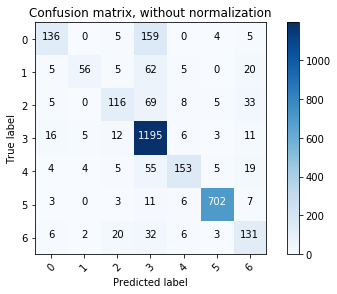

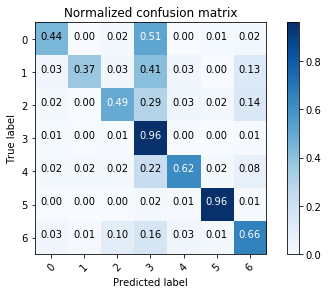

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 10   0   2  23   0   0   0]
 [  0   4   2   8   0   3   1]
 [  1   0   7   1   8   9   1]
 [  3   1   0 130   0   1   4]
 [  0   1   1  14   8   0   4]
 [  0   0   0   3   0  79   0]
 [  0   0   5   8   1   0   9]]
Normalized confusion matrix
[[0.28571429 0.         0.05714286 0.65714286 0.         0.
  0.        ]
 [0.         0.22222222 0.11111111 0.44444444 0.         0.16666667
  0.05555556]
 [0.03703704 0.         0.25925926 0.03703704 0.2962963  0.33333333
  0.03703704]
 [0.02158273 0.00719424 0.         0.9352518  0.         0.00719424
  0.02877698]
 [0.         0.03571429 0.03571429 0.5        0.28571429 0.
  0.14285714]
 [0.         0.         0.         0.03658537 0.         0.96341463
  0.        ]
 [0.         0.         0.2173913  0.34782609 0.04347826 0.
  0.39130435]]


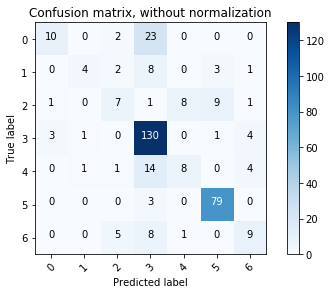

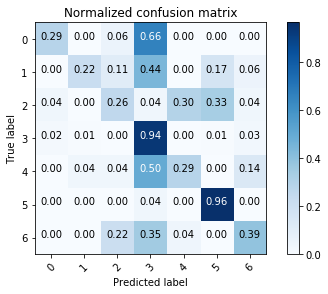

In [21]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [22]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7017


In [23]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_1st_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_1st_net_test_X_100_chars_GLOVE_FR.npy"

file_path_train_y = "./LSTM_results_char_emb/France_ByMeaning_1st_net_train_y.npy"
file_path_test_y = "./LSTM_results_char_emb/France_ByMeaning_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

Wall time: 14.8 s


### 2

In [24]:
%%time
# Lets try one another architecture

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape))
model.add(Dropout(0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 161,107
Trainable params: 161,107
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 23s 7ms/step - loss: 1.6973 - acc: 0.3852 - val_loss: 1.6505 - val_acc: 0.3949
Epoch 2/200
3123/3123 [==============================] - 21s 7ms/step - loss: 1.6482 - acc: 0.4070 - val_loss: 1.6246 - val_acc: 0.3949
Epoch 3/200
3123/3123 [==============================] - 20s 6ms/step - loss

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 218    1   18   62    1    6    3]
 [   9   74    9   36    5    4   16]
 [   7    1  182   15    4    8   19]
 [  30    6   27 1142    7   12   24]
 [   3    0   18   22  176    4   22]
 [   0    0    4    3    1  723    1]
 [   2    3   24   20   10    3  138]]
Normalized confusion matrix
[[0.70550162 0.00323625 0.05825243 0.20064725 0.00323625 0.01941748
  0.00970874]
 [0.05882353 0.48366013 0.05882353 0.23529412 0.03267974 0.02614379
  0.10457516]
 [0.02966102 0.00423729 0.77118644 0.06355932 0.01694915 0.03389831
  0.08050847]
 [0.02403846 0.00480769 0.02163462 0.9150641  0.00560897 0.00961538
  0.01923077]
 [0.0122449  0.         0.07346939 0.08979592 0.71836735 0.01632653
  0.08979592]
 [0.         0.         0.00546448 0.00409836 0.00136612 0.98770492
  0.00136612]
 [0.01       0.015      0.12       0.1        0.05       0.015
  0.69      ]]


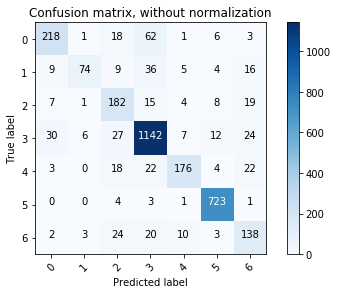

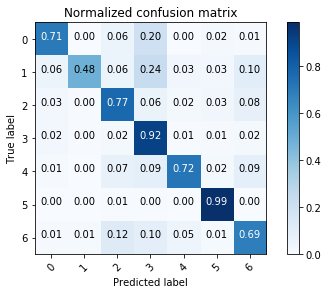

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 17   0   2  16   0   0   0]
 [  0   8   1   3   1   3   2]
 [  0   0  20   2   0   3   2]
 [ 10   0  11 108   3   1   6]
 [  0   1   0  11  13   0   3]
 [  0   0   0   1   0  81   0]
 [  0   0   5   2   2   0  14]]
Normalized confusion matrix
[[0.48571429 0.         0.05714286 0.45714286 0.         0.
  0.        ]
 [0.         0.44444444 0.05555556 0.16666667 0.05555556 0.16666667
  0.11111111]
 [0.         0.         0.74074074 0.07407407 0.         0.11111111
  0.07407407]
 [0.07194245 0.         0.07913669 0.77697842 0.02158273 0.00719424
  0.04316547]
 [0.         0.03571429 0.         0.39285714 0.46428571 0.
  0.10714286]
 [0.         0.         0.         0.01219512 0.         0.98780488
  0.        ]
 [0.         0.         0.2173913  0.08695652 0.08695652 0.
  0.60869565]]


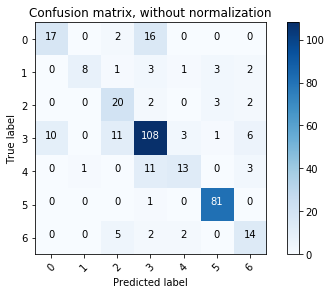

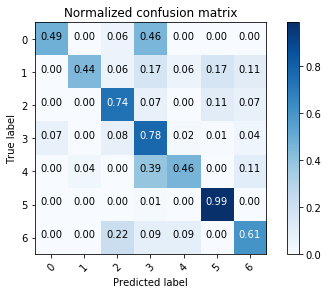

In [25]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [26]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7415


In [27]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_2nd_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_2nd_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"
1
np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 14.9 s


### 3

In [28]:
%%time
# and another

# with recurrent droupout
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 161,107
Trainable params: 161,107
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 23s 7ms/step - loss: 1.6772 - acc: 0.3993 - val_loss: 1.6446 - val_acc: 0.3949
Epoch 2/200
3123/3123 [==============================] - 20s 6ms/step - loss: 1.6325 - acc: 0.4070 - val_loss: 1.6102 - val_acc: 0.4972
Epoch 3/200
3123/3123 [==============================] - 20s 6ms/step - loss: 1.6058 - acc: 0.4307 - val_loss: 1.6006 - val_acc: 0.5028
Epoch 4/200
3123/3123 [==============================] - 21s 7ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 206    1   18   73    2    1    8]
 [   5   87    6   39    2    1   13]
 [   7    6  177   21    2    4   19]
 [  35   16   32 1134    8    4   19]
 [   4    5   24   26  167    3   16]
 [   1    2    6    9    2  706    6]
 [   3    6   27   17    7    2  138]]
Normalized confusion matrix
[[0.66666667 0.00323625 0.05825243 0.23624595 0.00647249 0.00323625
  0.02588997]
 [0.03267974 0.56862745 0.03921569 0.25490196 0.0130719  0.00653595
  0.08496732]
 [0.02966102 0.02542373 0.75       0.08898305 0.00847458 0.01694915
  0.08050847]
 [0.02804487 0.01282051 0.02564103 0.90865385 0.00641026 0.00320513
  0.01522436]
 [0.01632653 0.02040816 0.09795918 0.10612245 0.68163265 0.0122449
  0.06530612]
 [0.00136612 0.00273224 0.00819672 0.01229508 0.00273224 0.96448087
  0.00819672]
 [0.015      0.03       0.135      0.085      0.035      0.01
  0.69      ]]


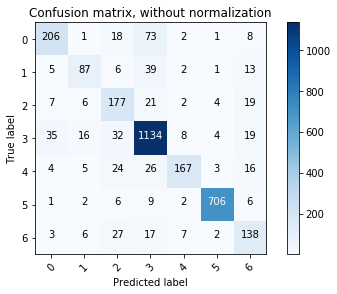

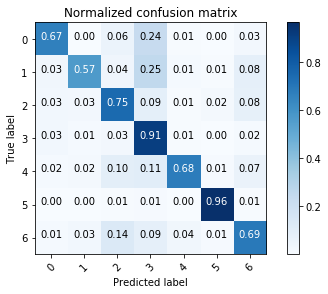

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 15   1   1  18   0   0   0]
 [  2   6   1   6   0   1   2]
 [  3   1  14   1   3   3   2]
 [  8   2   5 118   4   0   2]
 [  0   4   2   7  11   1   3]
 [  0   0   1   1   0  79   1]
 [  1   0   7   2   2   1  10]]
Normalized confusion matrix
[[0.42857143 0.02857143 0.02857143 0.51428571 0.         0.
  0.        ]
 [0.11111111 0.33333333 0.05555556 0.33333333 0.         0.05555556
  0.11111111]
 [0.11111111 0.03703704 0.51851852 0.03703704 0.11111111 0.11111111
  0.07407407]
 [0.05755396 0.01438849 0.03597122 0.84892086 0.02877698 0.
  0.01438849]
 [0.         0.14285714 0.07142857 0.25       0.39285714 0.03571429
  0.10714286]
 [0.         0.         0.01219512 0.01219512 0.         0.96341463
  0.01219512]
 [0.04347826 0.         0.30434783 0.08695652 0.08695652 0.04347826
  0.43478261]]


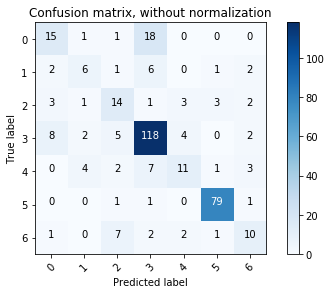

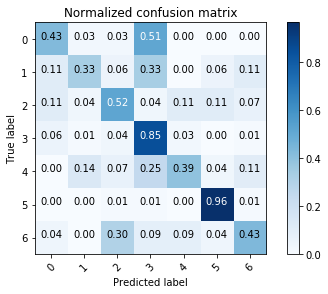

In [29]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [32]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7188


In [31]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_3rd_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_3rd_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 16 s


### 4

In [33]:
%%time
# and two LSTM's

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 100)          160400    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 1407      
Total params: 402,607
Trainable params: 402,607
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 44s 14ms/step - loss: 1.6900 - acc: 0.3852 - val_loss: 1.6552 - val_acc: 0.3949
Epoch 2/200
3123/3123 [==============================] - 41s 13ms/step - loss: 1.6408 - acc: 0.4025 - val_loss: 1.5983 - val_acc: 0.3949
Epoch 3/200
3123/3123 [==============================] - 41s 13ms/step - l

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 259    2    5   36    2    1    4]
 [   5  118    0   21    1    1    7]
 [  11    1  202   14    2    0    6]
 [  14    9   11 1201    8    1    4]
 [   0    1    7   12  213    1   11]
 [   2    0    1    4    0  722    3]
 [   1    1   12   23    6    0  157]]
Normalized confusion matrix
[[8.38187702e-01 6.47249191e-03 1.61812298e-02 1.16504854e-01
  6.47249191e-03 3.23624595e-03 1.29449838e-02]
 [3.26797386e-02 7.71241830e-01 0.00000000e+00 1.37254902e-01
  6.53594771e-03 6.53594771e-03 4.57516340e-02]
 [4.66101695e-02 4.23728814e-03 8.55932203e-01 5.93220339e-02
  8.47457627e-03 0.00000000e+00 2.54237288e-02]
 [1.12179487e-02 7.21153846e-03 8.81410256e-03 9.62339744e-01
  6.41025641e-03 8.01282051e-04 3.20512821e-03]
 [0.00000000e+00 4.08163265e-03 2.85714286e-02 4.89795918e-02
  8.69387755e-01 4.08163265e-03 4.48979592e-02]
 [2.73224044e-03 0.00000000e+00 1.36612022e-03 5.46448087e-03
  0.00000000e+00 9.86338798e-0

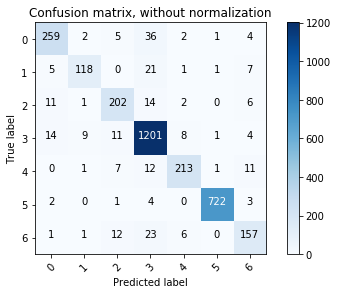

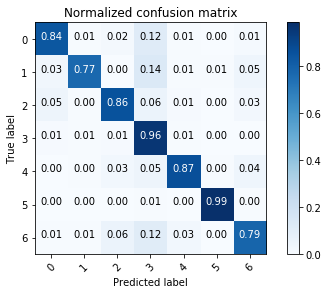

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 20   0   2  13   0   0   0]
 [  0   6   2   8   1   0   1]
 [  1   0  17   1   2   3   3]
 [  6   1   2 121   3   2   4]
 [  0   2   0  10  13   1   2]
 [  0   0   1   1   0  78   2]
 [  0   1   5   7   1   0   9]]
Normalized confusion matrix
[[0.57142857 0.         0.05714286 0.37142857 0.         0.
  0.        ]
 [0.         0.33333333 0.11111111 0.44444444 0.05555556 0.
  0.05555556]
 [0.03703704 0.         0.62962963 0.03703704 0.07407407 0.11111111
  0.11111111]
 [0.04316547 0.00719424 0.01438849 0.8705036  0.02158273 0.01438849
  0.02877698]
 [0.         0.07142857 0.         0.35714286 0.46428571 0.03571429
  0.07142857]
 [0.         0.         0.01219512 0.01219512 0.         0.95121951
  0.02439024]
 [0.         0.04347826 0.2173913  0.30434783 0.04347826 0.
  0.39130435]]


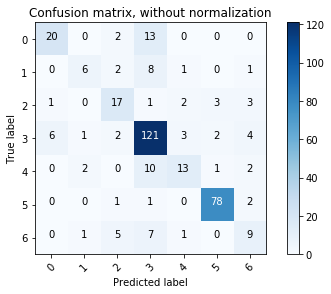

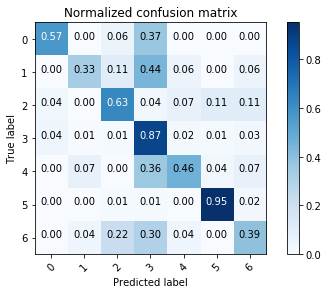

In [34]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [35]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7500


In [36]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_4th_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_4th_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 31.6 s


### 5

In [ ]:
%%time
# and also with 1d-convolutional layer

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_emb_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 707       
Total params: 82,739
Trainable params: 82,739
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200


TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 147    2    9  138    4    3    6]
 [   3   52    8   72    6    6    6]
 [  11    6  146   62    7    0    4]
 [  16    7   15 1161    9   28   12]
 [   2    4   16   59  150    5    9]
 [   6    0    3   74    2  641    6]
 [   3    3   31   79    7    9   68]]
Normalized confusion matrix
[[0.47572816 0.00647249 0.02912621 0.44660194 0.01294498 0.00970874
  0.01941748]
 [0.01960784 0.33986928 0.05228758 0.47058824 0.03921569 0.03921569
  0.03921569]
 [0.04661017 0.02542373 0.61864407 0.26271186 0.02966102 0.
  0.01694915]
 [0.01282051 0.00560897 0.01201923 0.93028846 0.00721154 0.0224359
  0.00961538]
 [0.00816327 0.01632653 0.06530612 0.24081633 0.6122449  0.02040816
  0.03673469]
 [0.00819672 0.         0.00409836 0.1010929  0.00273224 0.87568306
  0.00819672]
 [0.015      0.015      0.155      0.395      0.035      0.045
  0.34      ]]


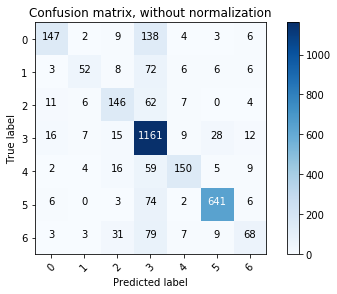

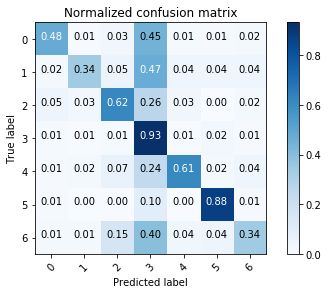

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 14   0   2  15   1   2   1]
 [  0   2   4   9   0   2   1]
 [  0   0  19   6   0   0   2]
 [  5   0   1 124   3   5   1]
 [  0   2   0  14  11   0   1]
 [  0   0   0   9   0  73   0]
 [  2   0   9   6   0   1   5]]
Normalized confusion matrix
[[0.4        0.         0.05714286 0.42857143 0.02857143 0.05714286
  0.02857143]
 [0.         0.11111111 0.22222222 0.5        0.         0.11111111
  0.05555556]
 [0.         0.         0.7037037  0.22222222 0.         0.
  0.07407407]
 [0.03597122 0.         0.00719424 0.89208633 0.02158273 0.03597122
  0.00719424]
 [0.         0.07142857 0.         0.5        0.39285714 0.
  0.03571429]
 [0.         0.         0.         0.1097561  0.         0.8902439
  0.        ]
 [0.08695652 0.         0.39130435 0.26086957 0.         0.04347826
  0.2173913 ]]


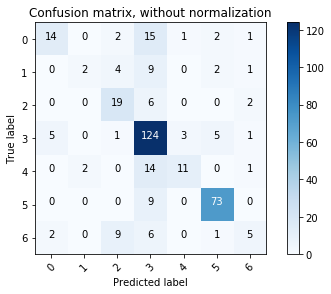

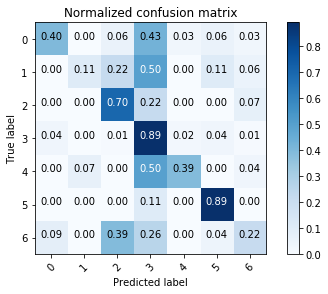

In [21]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [22]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7045


In [23]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_5th_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_5th_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 12 s


### 6

In [24]:
%%time

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_emb_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 82,739
Trainable params: 82,739
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 71s 23ms/step - loss: 1.5380 - acc: 0.4701 - val_loss: 1.3836 - val_acc: 0.5483
Epoch 2/200
3123/3123 [==============================] - 67s 22ms/step - loss: 1.

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 230    1    7   49    3    7   12]
 [   0   92    8   32    2   13    6]
 [   5    4  185   22    4    7    9]
 [  12   14   24 1136    6   45   11]
 [   3    7   19   15  191    5    5]
 [   3    1    3   34    3  679    9]
 [   7    5   22   35    4    9  118]]
Normalized confusion matrix
[[0.74433657 0.00323625 0.02265372 0.15857605 0.00970874 0.02265372
  0.03883495]
 [0.         0.60130719 0.05228758 0.20915033 0.0130719  0.08496732
  0.03921569]
 [0.02118644 0.01694915 0.78389831 0.09322034 0.01694915 0.02966102
  0.03813559]
 [0.00961538 0.01121795 0.01923077 0.91025641 0.00480769 0.03605769
  0.0088141 ]
 [0.0122449  0.02857143 0.07755102 0.06122449 0.77959184 0.02040816
  0.02040816]
 [0.00409836 0.00136612 0.00409836 0.04644809 0.00409836 0.92759563
  0.01229508]
 [0.035      0.025      0.11       0.175      0.02       0.045
  0.59      ]]


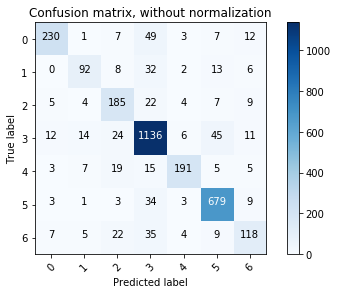

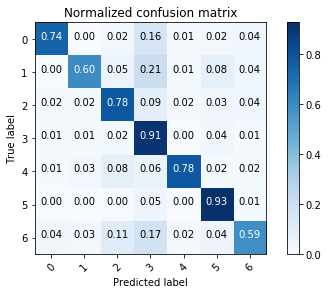

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 22   0   4   8   1   0   0]
 [  1   5   2   7   1   1   1]
 [  0   1  20   3   1   0   2]
 [  6   0   7 118   2   5   1]
 [  0   1   0  14  10   3   0]
 [  1   0   2   7   0  72   0]
 [  1   0  13   2   2   0   5]]
Normalized confusion matrix
[[0.62857143 0.         0.11428571 0.22857143 0.02857143 0.
  0.        ]
 [0.05555556 0.27777778 0.11111111 0.38888889 0.05555556 0.05555556
  0.05555556]
 [0.         0.03703704 0.74074074 0.11111111 0.03703704 0.
  0.07407407]
 [0.04316547 0.         0.05035971 0.84892086 0.01438849 0.03597122
  0.00719424]
 [0.         0.03571429 0.         0.5        0.35714286 0.10714286
  0.        ]
 [0.01219512 0.         0.02439024 0.08536585 0.         0.87804878
  0.        ]
 [0.04347826 0.         0.56521739 0.08695652 0.08695652 0.
  0.2173913 ]]


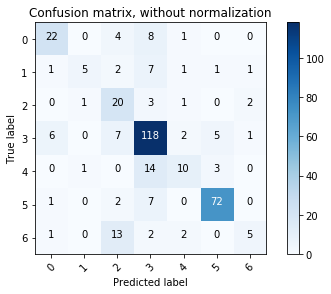

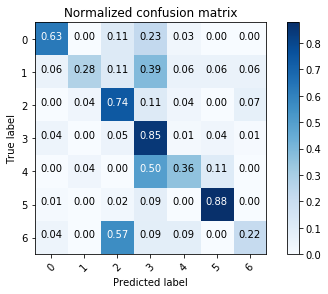

In [25]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [26]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7159


In [27]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_6th_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_6th_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 13.3 s
